In [1]:
from sedona.spark import SedonaContext

config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.7.1",
            "org.datasyslab:geotools-wrapper:1.7.0-28.5",
            "org.apache.hadoop:hadoop-aws:3.3.2"
        ])
    )
    .config("spark.jars.repositories", "https://artifacts.unidata.ucar.edu/repository/unidata-all")        
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
        "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.executor.memory", "12G")
    .config("spark.driver.memory", "12G")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

sedona = SedonaContext.create(config)
sedona.sparkContext.setLogLevel("ERROR")

sedona.conf.set("fs.https.impl", "org.apache.hadoop.fs.http.HttpsFileSystem")

https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /Users/mattforrest/.ivy2/cache
The jars for the packages stored in: /Users/mattforrest/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.5_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-eb9c36b4-3232-48fe-bd11-fc4a5f9bc96f;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-shaded-3.5_2.12;1.7.1 in central
	found org.datasyslab#geotools-wrapper;1.7.0-28.5 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 130ms :: artifacts dl 4ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.a

:: loading settings :: url = jar:file:/Users/mattforrest/Documents/sedona-tutorial/.venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


25/06/03 14:20:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Part 1: Simple Example

## Create a Dataframe

In [2]:
from pyspark.sql import Row

In [3]:
data = [
    Row(id=1, name="Point A", lat=40.7128, lon=-74.0060),
    Row(id=2, name="Point B", lat=34.0522, lon=-118.2437),
    Row(id=3, name="Point C", lat=37.7749, lon=-122.4194)
]

In [4]:
df = sedona.createDataFrame(data)
df.show()

+---+-------+-------+---------+
| id|   name|    lat|      lon|
+---+-------+-------+---------+
|  1|Point A|40.7128|  -74.006|
|  2|Point B|34.0522|-118.2437|
|  3|Point C|37.7749|-122.4194|
+---+-------+-------+---------+



In [5]:
from pyspark.sql.functions import expr

In [6]:
df_geom = df.withColumn("geom", 
                        expr("ST_Point(cast(lon as Decimal(24, 20)), cast(lat as Decimal(24, 20)))"))

In [7]:
df_geom.show(truncate=False)

+---+-------+-------+---------+-------------------------+
|id |name   |lat    |lon      |geom                     |
+---+-------+-------+---------+-------------------------+
|1  |Point A|40.7128|-74.006  |POINT (-74.006 40.7128)  |
|2  |Point B|34.0522|-118.2437|POINT (-118.2437 34.0522)|
|3  |Point C|37.7749|-122.4194|POINT (-122.4194 37.7749)|
+---+-------+-------+---------+-------------------------+



## Simple Query

In [8]:
sql = """
SELECT ST_AreaSpheroid(
    ST_GeomFromWKT('Polygon ((34 35, 28 30, 25 34, 34 35))')
) as result
"""

In [9]:
sedona.sql(sql).show(truncate=False)

+---------------------+
|result               |
+---------------------+
|2.0182485081176245E11|
+---------------------+



## Spatial Filter

In [10]:
from pyspark.sql import Row

In [11]:
data = [
    Row(id=1, name="Point A", lat=40.7128, lon=-74.0060),
    Row(id=2, name="Point B", lat=34.0522, lon=-118.2437),
    Row(id=3, name="Point C", lat=37.7749, lon=-122.4194)
]

In [12]:
df = sedona.createDataFrame(data)
df.show()

+---+-------+-------+---------+
| id|   name|    lat|      lon|
+---+-------+-------+---------+
|  1|Point A|40.7128|  -74.006|
|  2|Point B|34.0522|-118.2437|
|  3|Point C|37.7749|-122.4194|
+---+-------+-------+---------+



In [13]:
from pyspark.sql.functions import expr

In [14]:
df_geom = df.withColumn("geom", expr("ST_Point(cast(lon as Decimal(24, 20)), cast(lat as Decimal(24, 20)))"))
df_geom.show(truncate=False)

+---+-------+-------+---------+-------------------------+
|id |name   |lat    |lon      |geom                     |
+---+-------+-------+---------+-------------------------+
|1  |Point A|40.7128|-74.006  |POINT (-74.006 40.7128)  |
|2  |Point B|34.0522|-118.2437|POINT (-118.2437 34.0522)|
|3  |Point C|37.7749|-122.4194|POINT (-122.4194 37.7749)|
+---+-------+-------+---------+-------------------------+



In [15]:
df_geom.createOrReplaceTempView("points")

In [16]:
sedona.sql("""
SELECT id, name, ST_AsText(geom) AS wkt
FROM points
WHERE ST_Within(geom, ST_GeomFromText('POLYGON((-120 20, -60 20, -60 50, -120 50, -120 20))'))
""").show(truncate=False)

+---+-------+-------------------------+
|id |name   |wkt                      |
+---+-------+-------------------------+
|1  |Point A|POINT (-74.006 40.7128)  |
|2  |Point B|POINT (-118.2437 34.0522)|
+---+-------+-------------------------+



## Same as above, but Pythonic

In [17]:
from sedona.sql.st_constructors import ST_GeomFromText
from sedona.sql.st_functions import ST_AsText
from sedona.sql.st_predicates import ST_Within
from pyspark.sql.functions import lit

In [18]:
polygon_wkt = 'POLYGON((-120 20, -60 20, -60 50, -120 50, -120 20))'
polygon_geom = ST_GeomFromText(lit(polygon_wkt))

In [19]:
df_filtered = df_geom.filter(
    ST_Within(df_geom["geom"], polygon_geom)). \
    select(
        "id", "name", ST_AsText("geom").alias("wkt")
    )

df_filtered.show(truncate=False)

+---+-------+-------------------------+
|id |name   |wkt                      |
+---+-------+-------------------------+
|1  |Point A|POINT (-74.006 40.7128)  |
|2  |Point B|POINT (-118.2437 34.0522)|
+---+-------+-------------------------+



# Part 2: Reading Vector Data

In [20]:
geojson_path = 'data/Neighborhood_Map_Atlas_Neighborhoods.geojson'
geojson_df = sedona.read.format("geojson").load(geojson_path)

In [21]:
geojson_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- geometry: geometry (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- L_HOOD: string (nullable = true)
 |    |-- OBJECTID: long (nullable = true)
 |    |-- S_HOOD: string (nullable = true)
 |    |-- S_HOOD_ALT_NAMES: string (nullable = true)
 |    |-- Shape__Area: double (nullable = true)
 |    |-- Shape__Length: double (nullable = true)
 |-- type: string (nullable = true)



In [22]:
from pyspark.sql.functions import expr

In [23]:
geojson_df = (
    sedona.read.format("geojson").option("multiLine", "true").load(geojson_path)
    .selectExpr("explode(features) as features")
    .select("features.*")
    .withColumn("L_HOOD", expr("properties['L_HOOD']"))
    .withColumn("OBJECTID", expr("properties['OBJECTID']"))
    .withColumn("S_HOOD", expr("properties['S_HOOD']"))
    .withColumn("S_HOOD_ALT_NAMES", expr("properties['S_HOOD_ALT_NAMES']"))
    .drop("properties").drop("type")
)

In [24]:
geojson_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- L_HOOD: string (nullable = true)
 |-- OBJECTID: long (nullable = true)
 |-- S_HOOD: string (nullable = true)
 |-- S_HOOD_ALT_NAMES: string (nullable = true)



In [25]:
geojson_df.count()

94

In [26]:
df = (
    sedona.read.format("geopackage")
    .option("showMetadata", "true")
    .load("data/parks.gpkg")
)
df.show()

+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+
|table_name|data_type|identifier|         description|         last_change|          min_x|            min_y|            max_x|            max_y|srs_id|
+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+
|     parks| features| DPR.Parks|Locations of Seat...|2025-05-07 16:37:...|1244524.2382299|185216.9820538014|1292596.322203636|271529.3333788812|100000|
+----------+---------+----------+--------------------+--------------------+---------------+-----------------+-----------------+-----------------+------+



In [27]:
df = (
    sedona.read.format("geopackage")
    .option("tableName", "parks")
    .load("data/parks.gpkg")
)
df.show()

+---+--------------------+--------------------+--------------------+-----------------+----------+---------+----+-----+-----+-----+----+----------+--------+----------+-----------------+-----+----------+----------+----------+--------------------+
|fid|                geom|                NAME|            PMA_NAME|          ADDRESS|       PIN|SUBPARCEL| PMA|OWNER|LEASE|MAINT|USE_|  ACQ_DATE|NAMEFLAG|REVIEW_DAT|           AMWOID| SDQL|SE_ANNO_CA|GIS_CRT_DT|GIS_EDT_DT|            GlobalID|
+---+--------------------+--------------------+--------------------+-----------------+----------+---------+----+-----+-----+-----+----+----------+--------+----------+-----------------+-----+----------+----------+----------+--------------------+
|  1|MULTIPOLYGON (((1...|                NULL|                NULL|             NULL|2489200285|    16822|4463|  SPU|    N|  SPU|NULL|1899-12-30|       0|2011-03-09|   PROPERTY-MYRES|QL-D3|      NULL|2025-05-07|2025-05-07|dc828a5f-e037-4a5...|
|  2|MULTIPOLYGON ((

In [28]:
shapefile_path = 'data/parks/'
shapefile_df = sedona.read.format("shapefile").load(shapefile_path)

In [29]:
# CSV - https://www.kaggle.com/datasets/andykrause/kingcountysales
csv_path = 'data/kingco_sales.csv'
csv_df = sedona.read.format("csv").load(csv_path)
csv_df.show(3)

+----+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+
| _c0|      _c1|         _c2|       _c3|       _c4|     _c5|         _c6|        _c7|      _c8|             _c9|             _c10|_c11|       _c12|   _c13|                _c14|       _c15|    _c16|   _c17|      _c18|     _c19|    _c20|_c21|  _c22|      _c23| _c24|       _c25|     _c26|   _c27|_c28|     _c29|     _c30|     _c31|     _c32|     _c33|_c34|_c35|     _c36|         _c37|        _c38|         _c39|         _c40|            _c41|        _c42|      _c43|    

In [30]:
# Read CSV with header and inferSchema
csv_df = sedona.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(csv_path)

csv_df.show(3)

+---+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+
|_c0|  sale_id|        pinx| sale_date|sale_price|sale_nbr|sale_warning|join_status|join_year|        latitude|        longitude|area|       city| zoning|         subdivision|present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|condition|stories|beds|bath_full|bath_3qtr|bath_half|garb_sqft|gara_sqft|wfnt|golf|greenbelt|noise_traffic|view_rainier|view_olympics|view_cascades|view_territorial|view_skyline|view_sound|view_l

In [31]:
from pyspark.sql.functions import col

In [32]:
csv_df = csv_df.selectExpr(
    "*", "ST_Point(longitude, latitude) as geometry")

In [33]:
csv_df.show(3)

+---+---------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+--------------------+
|_c0|  sale_id|        pinx| sale_date|sale_price|sale_nbr|sale_warning|join_status|join_year|        latitude|        longitude|area|       city| zoning|         subdivision|present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|condition|stories|beds|bath_full|bath_3qtr|bath_half|garb_sqft|gara_sqft|wfnt|golf|greenbelt|noise_traffic|view_rainier|view_olympics|view_cascades|view_territorial|view_skyl

In [34]:
csv_df.count()

591513

In [35]:
# GeoParquet
geoparquet_path = 'data/Seattle_Transportation_Plan_Bicycle_Element_829016546957421557.parquet'
geoparquet_df = sedona.read.format("geoparquet").load(geoparquet_path)
geoparquet_df.show(3)

+--------+--------------+---------------------+--------------------+-------+-----------+
|OBJECTID| artclass_desc|bike_network_category|            geometry|     id| stname_ord|
+--------+--------------+---------------------+--------------------+-------+-----------+
|     1.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....|23677.0| E ALDER ST|
|     2.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....|20052.0| NE 55TH ST|
|     3.0|Not Designated| Proposed Bike+ - ...|LINESTRING (-122....| 5667.0|23RD AVE NW|
+--------+--------------+---------------------+--------------------+-------+-----------+
only showing top 3 rows



In [36]:
geoparquet_df.selectExpr('ST_SRID(geometry)').show(1)

+-----------------+
|st_srid(geometry)|
+-----------------+
|                0|
+-----------------+
only showing top 1 row



In [37]:
geoparquet_df.selectExpr('''ST_Transform(geometry, 'EPSG:2926', 'EPSG:4326')''').show(1)

+--------------------------------------------+
|st_transform(geometry, EPSG:2926, EPSG:4326)|
+--------------------------------------------+
|                        LINESTRING (-127....|
+--------------------------------------------+
only showing top 1 row



In [38]:
# GeoParquet
geoparquet_schools_path = 'data/Seattle_Public_Schools_Sites_2023-2024.parquet'
geoparquet_schools_df = sedona.read.format("geoparquet").load(geoparquet_schools_path)
geoparquet_schools_df.show(3)

+----------------+-----------------+--------+-------------------+------+--------------------+------+--------------+---------+--------------+------+-----------+-------+
|        Latitude|        Longitude|OBJECTID|            address|esmshs|            geometry|grades|      mapLabel|school_ID|   school_name|siteID|     status|    zip|
+----------------+-----------------+--------+-------------------+------+--------------------+------+--------------+---------+--------------+------+-----------+-------+
| 47.709950686514|-122.293023646655|     1.0| 11051 34th Ave. NE|    MS|POINT (-122.29300...|   6-8|   Jane Addams|    106.0|Jane Addams MS| 106.0|         MS|98125.0|
|47.7134360540258|-122.314672965205|     2.0| 11530 12th Ave. NE|    ES|POINT (-122.31465...|   K-8|Hazel Wolf K-8|    292.0|Hazel Wolf K-8| 263.0|Option ELEM|98125.0|
|47.4988691374883|-122.263186633228|     3.0|11650 Beacon Ave. S|    ES|POINT (-122.26317...|   K-5|  Rainier View|    264.0|  Rainier View| 264.0|       ELEM|9

# Part 3: Loading Raster Data

In [3]:
netcdf_file = "data/pdsi_current_PRISM.nc"
netcdf_df = sedona.read.format("binaryFile").load(netcdf_file)
netcdf_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/Users/mattf...|2025-05-22 11:10:...|3499588|[43 44 46 01 00 0...|
+--------------------+--------------------+-------+--------------------+



In [4]:
import pyspark.sql.functions as f

In [5]:
netcdf_df.repartition(8)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [6]:
netcdf_df = netcdf_df.withColumn("raster", f.expr("RS_FromNetCDF(content, 'data', 'longitude', 'latitude')"))

In [7]:
netcdf_df.show()

+--------------------+--------------------+-------+--------------------+--------------------+
|                path|    modificationTime| length|             content|              raster|
+--------------------+--------------------+-------+--------------------+--------------------+
|file:/Users/mattf...|2025-05-22 11:10:...|3499588|[43 44 46 01 00 0...|GridCoverage2D["g...|
+--------------------+--------------------+-------+--------------------+--------------------+



In [8]:
# https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_10TET_20250423_0_L2A?.asset=asset-nir

## GeoTIFF

In [9]:
# https://browser.apex.esa.int/external/eoresults.esa.int/stac/collections/ESA_WORLDCOVER_10M_2021_V2/items/ESA_WorldCover_10m_2021_v200_N45W123?.asset=asset-esa_worldcover_10m_map

In [19]:
raster_df = sedona.read.format("binaryFile") \
    .load("data/ESA_WorldCover_10m_2021_v200_N45W123_Map.tif")

In [20]:
raster_df = raster_df.withColumn("raster", f.expr("RS_FromGeoTiff(content)"))

In [12]:
# raster_df.show()

In [13]:
raster_df.repartition(8)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary, raster: udt]

In [14]:
raster_df.selectExpr("RS_TileExplode(raster, 256, 256) as (x, y, raster)").show()

+---+---+--------------------+
|  x|  y|              raster|
+---+---+--------------------+
|  0|  0|GridCoverage2D["g...|
|  1|  0|GridCoverage2D["g...|
|  2|  0|GridCoverage2D["g...|
|  3|  0|GridCoverage2D["g...|
|  4|  0|GridCoverage2D["g...|
|  5|  0|GridCoverage2D["g...|
|  6|  0|GridCoverage2D["g...|
|  7|  0|GridCoverage2D["g...|
|  8|  0|GridCoverage2D["g...|
|  9|  0|GridCoverage2D["g...|
| 10|  0|GridCoverage2D["g...|
| 11|  0|GridCoverage2D["g...|
| 12|  0|GridCoverage2D["g...|
| 13|  0|GridCoverage2D["g...|
| 14|  0|GridCoverage2D["g...|
| 15|  0|GridCoverage2D["g...|
| 16|  0|GridCoverage2D["g...|
| 17|  0|GridCoverage2D["g...|
| 18|  0|GridCoverage2D["g...|
| 19|  0|GridCoverage2D["g...|
+---+---+--------------------+
only showing top 20 rows



# Part 4: PySpark and SparkSQL

In [49]:
shapefile_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- NAME: string (nullable = true)
 |-- PMA_NAME: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- PIN: string (nullable = true)
 |-- SUBPARCEL: long (nullable = true)
 |-- PMA: long (nullable = true)
 |-- OWNER: string (nullable = true)
 |-- LEASE: string (nullable = true)
 |-- MAINT: string (nullable = true)
 |-- USE_: string (nullable = true)
 |-- ACQ_DATE: date (nullable = true)
 |-- NAMEFLAG: long (nullable = true)
 |-- REVIEW_DAT: date (nullable = true)
 |-- AMWOID: string (nullable = true)
 |-- SDQL: string (nullable = true)
 |-- SE_ANNO_CA: string (nullable = true)
 |-- GIS_CRT_DT: date (nullable = true)
 |-- GIS_EDT_DT: date (nullable = true)
 |-- GlobalID: string (nullable = true)



In [50]:
csv_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- sale_id: string (nullable = true)
 |-- pinx: string (nullable = true)
 |-- sale_date: date (nullable = true)
 |-- sale_price: integer (nullable = true)
 |-- sale_nbr: string (nullable = true)
 |-- sale_warning: string (nullable = true)
 |-- join_status: string (nullable = true)
 |-- join_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- area: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- zoning: string (nullable = true)
 |-- subdivision: string (nullable = true)
 |-- present_use: integer (nullable = true)
 |-- land_val: integer (nullable = true)
 |-- imp_val: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- year_reno: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- sqft_1: integer (nullable = true)
 |-- sqft_fbsmt: integer (nullable = true)
 |-- grade: integer (nullabl

In [51]:
shapefile_df.selectExpr('ST_SRID(geometry)').first()

Row(st_srid(geometry)=0)

In [52]:
csv_df.selectExpr('ST_SRID(geometry)').first()

Row(st_srid(geometry)=0)

In [53]:
shapefile_df.createOrReplaceTempView("polygons")
csv_df.createOrReplaceTempView("points")

In [54]:
%%time
sedona.sql("""
    SELECT p.sale_id AS point_id, poly.NAME AS park_name
    FROM points p
    JOIN polygons poly
    ON ST_DWithin(
        ST_Transform(poly.geometry, 'EPSG:2926', 'EPSG:26910'), 
        ST_Transform(p.geometry, 'EPSG:4326', 'EPSG:26910'), 
    30)
""").count()

CPU times: user 6.77 ms, sys: 9 ms, total: 15.8 ms
Wall time: 10 s


10048

In [55]:
from pyspark.sql.functions import expr

# Transform geometries to EPSG:26910 (UTM zone), then apply ST_DWithin
transformed_points = csv_df.withColumn(
    "geom_utm", expr("ST_Transform(geometry, 'EPSG:4326', 'EPSG:26910')")
)

transformed_polygons = shapefile_df.withColumn(
    "geom_utm", expr("ST_Transform(geometry, 'EPSG:2926', 'EPSG:26910')")
)

# Perform spatial join using ST_DWithin
joined_df = transformed_points.alias("p").join(
    transformed_polygons.alias("poly"),
    expr("ST_DWithin(poly.geom_utm, p.geom_utm, 30)")
)

# Count matching pairs
joined_df.count()

10048

# Part 5: DataFrame Operations

In [65]:
csv_df.show(5, truncate=False)

+---+----------+------------+----------+----------+--------+------------+-----------+---------+----------------+-----------------+----+-----------+-------+---------------------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+------------------------------------------+
|_c0|sale_id   |pinx        |sale_date |sale_price|sale_nbr|sale_warning|join_status|join_year|latitude        |longitude        |area|city       |zoning |subdivision                      |present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|condition|stories|beds|bath_full|bath_3qtr|bath_half|garb_sqft|gara_sqft|wfnt|golf|greenbelt|noise_traffic|view_rainier|view

In [66]:
csv_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- sale_id: string (nullable = true)
 |-- pinx: string (nullable = true)
 |-- sale_date: date (nullable = true)
 |-- sale_price: integer (nullable = true)
 |-- sale_nbr: string (nullable = true)
 |-- sale_warning: string (nullable = true)
 |-- join_status: string (nullable = true)
 |-- join_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- area: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- zoning: string (nullable = true)
 |-- subdivision: string (nullable = true)
 |-- present_use: integer (nullable = true)
 |-- land_val: integer (nullable = true)
 |-- imp_val: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- year_reno: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- sqft_1: integer (nullable = true)
 |-- sqft_fbsmt: integer (nullable = true)
 |-- grade: integer (nullabl

In [67]:
csv_df.select("sale_id", "sale_price").show()

+----------+----------+
|   sale_id|sale_price|
+----------+----------+
| 1999..144|    150000|
| 1999..258|    235000|
| 1999..775|    270000|
| 1999..957|    184250|
|1999..1155|    175000|
|1999..1267|    359850|
|1999..1335|    105000|
|1999..1354|    160000|
|1999..1424|    135000|
|1999..1464|    400000|
|1999..1760|    270000|
|1999..1809|    155000|
|1999..1862|    213000|
|1999..1948|    180000|
|1999..2096|    166000|
|1999..2544|    173500|
|1999..2609|    285000|
|1999..2667|    285000|
|1999..2673|    106000|
|1999..3089|     93650|
+----------+----------+
only showing top 20 rows



In [68]:
csv_df.count()

591513

In [69]:
points_df = csv_df.select("sale_id", "sale_price")

In [70]:
points_df.first()

Row(sale_id='1999..144', sale_price=150000)

In [71]:
points_df = csv_df.select("sale_id", "sale_price")

In [72]:
points_df.orderBy("sale_price").show()

+-----------+----------+
|    sale_id|sale_price|
+-----------+----------+
| 2017..8190|     50293|
|1999..45779|     50300|
| 2012..4276|     50462|
|2006..40079|     50500|
|1999..13205|     50667|
|2013..30936|     51000|
|1999..24514|     51580|
|2016..16348|     52000|
|1999..36999|     52000|
|1999..43760|     52350|
|2015..30978|     52400|
|2012..34562|     53000|
|2001..25638|     53000|
|1999..13515|     53000|
|2001..33319|     53500|
|2001..38018|     53500|
|2000..37605|     53752|
|1999..18634|     53927|
| 2009..2490|     54000|
|1999..13506|     54000|
+-----------+----------+
only showing top 20 rows



In [73]:
points_df.filter("sale_price > 500000").show()

+-----------+----------+
|    sale_id|sale_price|
+-----------+----------+
| 1999..8039|   1225000|
|1999..11552|    539320|
|1999..15054|   3902500|
|1999..16909|    520000|
|1999..19198|    531000|
|1999..19583|    750000|
|1999..20399|   2500000|
|1999..21267|    515000|
|1999..23693|    615000|
|1999..25093|    543000|
|1999..25263|    975000|
|1999..26456|   1000000|
|1999..27741|   1200000|
|1999..29598|   1400000|
|1999..30476|    725000|
|1999..31185|    515000|
|1999..33401|    631100|
|1999..34444|    540000|
|1999..36205|    908000|
|1999..36211|    908000|
+-----------+----------+
only showing top 20 rows



# Part 6: Vector and Raster Viz

,raster_image
0,

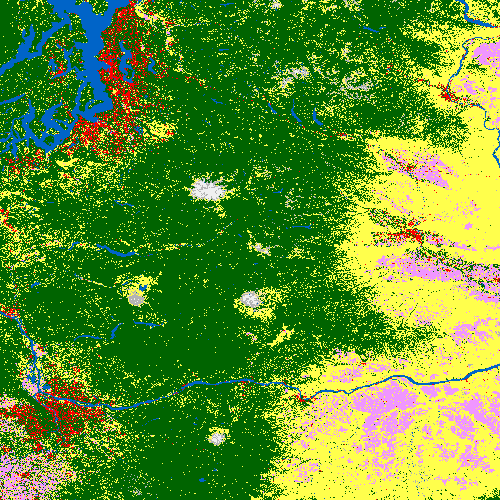

In [74]:
from sedona.spark import SedonaUtils

# Convert raster to base64 image for inline visualization
htmlDF = raster_df.selectExpr("RS_AsImage(raster, 500) as raster_image")

# Display in notebook (Jupyter or Databricks)
SedonaUtils.display_image(htmlDF)

In [75]:
from sedona.spark import SedonaKepler

map = SedonaKepler.create_map()
SedonaKepler.add_df(map, geoparquet_schools_df, name="Seattle Schools")
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Seattle Schools': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

# Part 7: Vector Functions

In [76]:
from sedona.sql.st_functions import ST_Buffer, ST_Transform, ST_ConvexHull

In [77]:
from pyspark.sql.functions import col, lit

buffered_df = geoparquet_schools_df.select(
    ST_Buffer(
        ST_Transform(col("geometry"), lit("EPSG:4326"), lit("EPSG:26910")),
        100
    ).alias("buffer")
)

buffered_df.show(3)

+--------------------+
|              buffer|
+--------------------+
|POLYGON ((553133....|
|POLYGON ((551505....|
|POLYGON ((555594....|
+--------------------+
only showing top 3 rows



In [78]:
map = SedonaKepler.create_map()
SedonaKepler.add_df(map, buffered_df, name="Seattle Schools Buffer")
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Seattle Schools Buffer': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …

In [79]:
schools_df = geoparquet_schools_df.selectExpr("*", "ST_Transform(geometry, 'EPSG:4326', 'EPSG:26910') as geom") \
    .drop("geometry") \
    .withColumnRenamed("geom", "geometry")

In [80]:
shapefile_df.createOrReplaceTempView('parks')

In [81]:
centroid = sedona.sql('''select st_centroid(geometry) from parks''')
centroid.show(3)

+---------------------+
|st_centroid(geometry)|
+---------------------+
| POINT (1258986.36...|
| POINT (1283739.51...|
| POINT (1264250.36...|
+---------------------+
only showing top 3 rows



In [82]:
area = sedona.sql('''select st_area(geometry) from parks''')
area.show(3)

+-----------------+
|st_area(geometry)|
+-----------------+
|6165.376032292017|
|36623.38040972915|
| 697.384598917983|
+-----------------+
only showing top 3 rows



In [83]:
geoparquet_df.createOrReplaceTempView('bikes')

In [84]:
length = sedona.sql('''select st_length(geometry) from bikes''')
length.show(3)

+--------------------+
| st_length(geometry)|
+--------------------+
|0.001305243327974...|
|0.001141705749637...|
|0.001882457746089...|
+--------------------+
only showing top 3 rows



In [85]:
hull_df = shapefile_df.select(
    "geometry",
    ST_ConvexHull("geometry").alias("convex_hull")
)
hull_df.show(3)

+--------------------+--------------------+
|            geometry|         convex_hull|
+--------------------+--------------------+
|POLYGON ((1258961...|POLYGON ((1259036...|
|POLYGON ((1283628...|POLYGON ((1283875...|
|POLYGON ((1264225...|POLYGON ((1264274...|
+--------------------+--------------------+
only showing top 3 rows



In [45]:
# Space Needle - -122.3494692, 47.6205426

In [ ]:
from pyspark.sql.functions import lit

dist_df = sedona.sql('''
select ST_Distance(geometry, 
                     ST_Transform(
                        ST_SetSRID(
                            ST_Point(-122.3494692, 47.6205426), 4326), 'EPSG:26910')) as distance
from parks                     
''')

dist_df.show(3)

+-----------------+
|         distance|
+-----------------+
|5053683.445720952|
|5053713.034321728|
|5053818.943766461|
+-----------------+
only showing top 3 rows



In [88]:
h3_df = sedona.sql('''
select ST_H3CellIDs(geometry, 8, true) as h3
from parks
limit 3
''')

h3_df.show()

+--------------------+
|                  h3|
+--------------------+
|[6129171281414717...|
|[6146282687939215...|
|[6136883206852444...|
+--------------------+



In [90]:
sedona.sql("""
SELECT ST_3DDistance(
    ST_GeomFromText('POINT Z (0 0 0)'),
    ST_GeomFromText('POINT Z (3 4 14)')
) AS dist_3d
""").show()

+------------------+
|           dist_3d|
+------------------+
|14.866068747318506|
+------------------+



# Part 8: Spatial Predicates

In [91]:
csv_df.createOrReplaceTempView('homes')
geojson_df.createOrReplaceTempView('neighborhoods')

In [92]:
geojson_df.show(3)

+--------------------+-------+--------+----------------+----------------+
|            geometry| L_HOOD|OBJECTID|          S_HOOD|S_HOOD_ALT_NAMES|
+--------------------+-------+--------+----------------+----------------+
|POLYGON ((-122.37...|Ballard|      27|   Loyal Heights|            NULL|
|POLYGON ((-122.37...|Ballard|      28|         Ballard|           Adams|
|POLYGON ((-122.37...|Ballard|      29|Whittier Heights|            NULL|
+--------------------+-------+--------+----------------+----------------+
only showing top 3 rows



In [93]:
sedona.sql('''
select h.sale_id, st_contains(n.geometry, h.geometry) in_ballard
from homes h
join neighborhoods n on st_contains(n.geometry, h.geometry)
where n.S_HOOD = 'Ballard'
''').show(3)

+-----------+----------+
|    sale_id|in_ballard|
+-----------+----------+
| 1999..2544|      true|
| 2000..9289|      true|
|2000..16882|      true|
+-----------+----------+
only showing top 3 rows



In [94]:
sedona.sql('''
select h.sale_id
from homes h
join neighborhoods n on st_dwithin(
    st_transform(n.geometry, 'EPSG:4326', 'EPSG:26910'), 
    st_transform(h.geometry, 'EPSG:4326', 'EPSG:26910'),
    500)
where n.S_HOOD = 'Ballard'
''').count()

6749

In [96]:
sedona.sql('''SELECT ST_Contains(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(5 5)')
) AS contains
''').show()

+--------+
|contains|
+--------+
|    true|
+--------+



In [ ]:
sedona.sql('''SELECT ST_Contains(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS contains
''').show()

+--------+
|contains|
+--------+
|    true|
+--------+



In [100]:
sedona.sql('''SELECT ST_Intersects(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('LINESTRING(5 5, 15 5)')
) AS intersects''').show()

+----------+
|intersects|
+----------+
|      true|
+----------+



In [101]:
sedona.sql('''SELECT ST_Intersects(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS intersects
''').show()

+----------+
|intersects|
+----------+
|      true|
+----------+



In [102]:
sedona.sql('''SELECT ST_Touches(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(0 0)')
) AS intersects
''').show()

+----------+
|intersects|
+----------+
|      true|
+----------+



In [103]:
sedona.sql('''SELECT ST_Touches(
  ST_GeomFromText('POLYGON((0 0, 0 10, 10 10, 10 0, 0 0))'),
  ST_GeomFromText('POINT(5 5)')
) AS intersects
''').show()

+----------+
|intersects|
+----------+
|     false|
+----------+



# Part 9: Write Data

In [104]:
# Write a single GeoJSON file (e.g., for download or web map use)
geojson_output_path = "parks.geojson"

shapefile_df.coalesce(1).write \
    .mode("overwrite") \
    .format("geojson") \
    .save(geojson_output_path)

In [105]:
# Repartition to 10 files for parallel writes
csv_df.repartition(10).write \
    .mode("overwrite") \
    .format("geoparquet") \
    .save("data/output_geoparquet_10_parts")

In [106]:
csv_df.write \
    .mode("overwrite") \
    .format("geoparquet") \
    .partitionBy("city") \
    .save("data/output_geoparquet_partitioned")

In [ ]:
# output_df.write \
#     .mode("overwrite") \
#     .format("geoparquet") \
#     .save("s3a://your-bucket-name/path/to/output/")

# Part 10: Nearest Neighbor Join

In [107]:
geoparquet_schools_df.repartition(8)

DataFrame[Latitude: double, Longitude: double, OBJECTID: double, address: string, esmshs: string, geometry: udt, grades: string, mapLabel: string, school_ID: double, school_name: string, siteID: double, status: string, zip: double]

In [108]:
geoparquet_schools_df.createOrReplaceTempView('schools')

In [153]:
nearest = sedona.sql('''
select schools.school_name, bikes.id
from schools
join bikes on ST_KNN(
    schools.geometry,
    bikes.geometry,
    3,
    true
)
''')

In [154]:
nearest.show(9)

+-----------+-------+
|school_name|     id|
+-----------+-------+
|   McGilvra| 6734.0|
|   McGilvra|16524.0|
|   McGilvra|23859.0|
| Aki Kurose|23150.0|
| Aki Kurose| 5899.0|
| Aki Kurose| 2447.0|
|  Wing Luke| 6393.0|
|  Wing Luke|14130.0|
|  Wing Luke|19894.0|
+-----------+-------+
only showing top 9 rows



# Part 11: Raster Functions

In [25]:
sample_area = 'POLYGON((-122.3608417185 47.6460037086, -122.3581854589 47.6460037086, -122.3581854589 47.643222509, -122.3608417185 47.643222509, -122.3608417185 47.6460037086))'

In [26]:
raster_df = raster_df.selectExpr("RS_TileExplode(raster, 256, 256) as (x, y, raster)")

In [27]:
raster_df.createOrReplaceTempView('landcover')

In [28]:
centroids = sedona.sql(f'''
select RS_PixelAsCentroids(raster, 1)
from landcover
where rs_intersects(raster, st_geomfromtext('{sample_area}'))
''')

In [29]:
centroids.show(3)

+------------------------------+
|rs_pixelascentroids(raster, 1)|
+------------------------------+
|          [{POINT (-122.381...|
|          [{POINT (-122.359...|
+------------------------------+



In [ ]:
raster_df.createOrReplaceTempView('landcover')

In [30]:
values = sedona.sql(f'''
select RS_Value(raster, ST_Point(-122.373894, 47.634587))
from landcover
where rs_intersects(raster, st_geomfromtext('{sample_area}'))
''')

In [ ]:
values.show()

+--------------------------------------------------+
|rs_value(raster, st_point(-122.373894, 47.634587))|
+--------------------------------------------------+
|                                              NULL|
|                                              NULL|
+--------------------------------------------------+

CPU times: user 4.28 ms, sys: 17.6 ms, total: 21.8 ms
Wall time: 24.9 s


In [32]:
raster_tiles = raster_df.selectExpr("RS_TileExplode(raster, 256, 256) as (x, y, raster)")

In [33]:
raster_tiles.createOrReplaceTempView('landcover_tiles')

In [ ]:
raster_tiles.show()

In [34]:
stats = sedona.sql('''SELECT RS_SummaryStatsAll(raster) AS stats
FROM landcover_tiles
where x = 0 and y = 0''')
stats.show(truncate=False)

+------------------------------------------------------------------------+
|stats                                                                   |
+------------------------------------------------------------------------+
|{65536.0, 671440.0, 10.245361328125, 2.2015958714443338, 10.0, 30.0}    |
|{65536.0, 745070.0, 11.368865966796875, 5.211732501959066, 10.0, 60.0}  |
|{65536.0, 752700.0, 11.48529052734375, 5.244017791375037, 10.0, 30.0}   |
|{65536.0, 689980.0, 10.52825927734375, 3.218597500507831, 10.0, 50.0}   |
|{65536.0, 777360.0, 11.861572265625, 6.324372179551169, 10.0, 80.0}     |
|{65536.0, 1805250.0, 27.545928955078125, 27.20680319857726, 10.0, 90.0} |
|{65536.0, 1952110.0, 29.786834716796875, 30.570124344786105, 10.0, 90.0}|
|{65536.0, 1041750.0, 15.895843505859375, 16.629436630696922, 10.0, 80.0}|
|{65536.0, 746490.0, 11.390533447265625, 6.187900336923004, 10.0, 80.0}  |
|{65536.0, 715940.0, 10.92437744140625, 4.278371406586183, 10.0, 50.0}   |
|{65536.0, 1434400.0, 21.

In [ ]:
metadata = sedona.sql('''SELECT RS_MetaData(raster) AS stats
FROM landcover_tiles
where x = 0 and y = 0''')
metadata.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|stats                                                                                                          |
+---------------------------------------------------------------------------------------------------------------+
|{-123.0, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0, 0.0, 4326, 1, 256, 256}             |
|{-122.97866666666667, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0, 0.0, 4326, 1, 256, 256}|
|{-122.95733333333334, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0, 0.0, 4326, 1, 256, 256}|
|{-122.936, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0, 0.0, 4326, 1, 256, 256}           |
|{-122.91466666666666, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0, 0.0, 4326, 1, 256, 256}|
|{-122.89333333333333, 48.0, 256, 256, 8.333333333333333E-5, -8.333333333333333E-5, 0.0,

# Part 12: Raster Map Algerbra (NDVI)

In [ ]:
# # https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a/items/S2A_10TET_20250423_0_L2A?.asset=asset-nir

In [2]:
from pyspark.sql import functions as f

In [3]:
red_df = sedona.read.format("binaryFile") \
    .load("data/B04.tif")

red_df = red_df.withColumn("raster", f.expr("RS_FromGeoTiff(content)"))

In [4]:
nir_df = sedona.read.format("binaryFile") \
    .load("data/B08.tif")

nir_df = nir_df.withColumn("raster", f.expr("RS_FromGeoTiff(content)"))

In [5]:
red_df.createOrReplaceTempView('red')
nir_df.createOrReplaceTempView('nir')

In [6]:
union = sedona.sql('''
select RS_Union(red.raster, nir.raster) as raster from red, nir
''')

In [7]:
union.createOrReplaceTempView('union')

In [ ]:
# NDVI = (NIR - Red) / (NIR + Red)

In [8]:
ndvi = sedona.sql('''
SELECT 
  RS_MapAlgebra(
    raster,                   
    'D',             
    'out = (rast[1] - rast[0])/(rast[1] + rast[0]);'
  ) AS ndvi
FROM union
''')

In [9]:
ndvi.show()

ANTLR Tool version 4.7.1 used for code generation does not match the current runtime version 4.9.3
ANTLR Runtime version 4.7.1 used for parser compilation does not match the current runtime version 4.9.3
ANTLR Tool version 4.7.1 used for code generation does not match the current runtime version 4.9.3
ANTLR Runtime version 4.7.1 used for parser compilation does not match the current runtime version 4.9.3


+--------------------+
|                ndvi|
+--------------------+
|GridCoverage2D["g...|
+--------------------+



,raster_image
0,

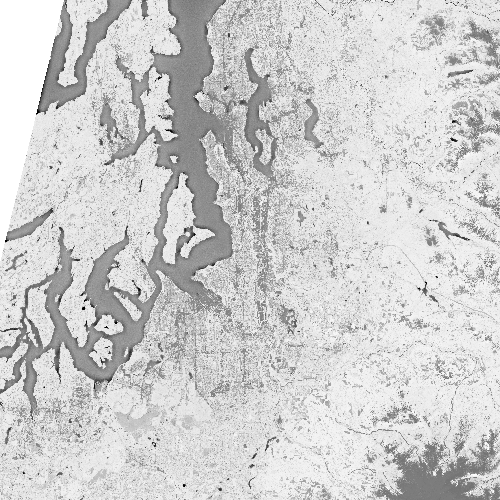

In [10]:
from sedona.spark import SedonaUtils

# Convert raster to base64 image for inline visualization
htmlDF = ndvi.selectExpr("RS_AsImage(ndvi, 500) as raster_image")

# Display in notebook (Jupyter or Databricks)
SedonaUtils.display_image(htmlDF)

# Part 13: Raster Writer

In [ ]:
# ndvi.withColumn("raster_binary", expr("RS_AsGeoTiff(ndvi)"))\
#   .write.format("raster")\
#   .option("rasterField", "raster_binary")\
#   .option("pathField", "path")\
#   .option("fileExtension", ".tiff")\
#   .mode("overwrite")\
#   .save("my_raster_file") 

# Part 14: Zonal Stats

In [11]:
ndvi.createOrReplaceTempView('ndvi')

In [12]:
park = 'POLYGON((-122.3607955072 47.6460058027, -122.3582580324 47.6460058027, -122.3582580324 47.6432482444, -122.3607955072 47.6432482444, -122.3607955072 47.6460058027))'

In [13]:
parks_ndvi = sedona.sql(f'''
select 
RS_ZonalStats(ndvi.ndvi, st_transform(
    st_geomfromtext('{park}'), 'epsg:4326', 'epsg:32610'
    ), 1, 'avg', false, false) as avg_ndvi
from ndvi
''')

In [14]:
ndvi = ndvi.repartition(8)

In [15]:
parks_ndvi.show(3)

+------------------+
|          avg_ndvi|
+------------------+
|0.7059917070910219|
+------------------+

